In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from tensorflow.keras import layers, models

styles = ['隸', '楷', '篆', '行', '草']
column_names = ["key", "character", "style", "author", "image"]

dataframe = pd.read_csv("./hanzi/data.csv", header=None, names = column_names)
authors = dataframe["author"].unique()
dataset_size = dataframe.shape[0]
np.random.shuffle(dataframe.values)

In [3]:
dataframe_train = dataframe.iloc[0:140000]
dataframe_validation = dataframe.iloc[140000:150000]
dataframe_validation.reset_index(drop=True, inplace=True)
dataframe_test = dataframe.iloc[150000:]
dataframe_test.reset_index(drop=True, inplace=True)

print(dataframe_train)
print(dataframe_validation)
print(dataframe_test)

       key character style author                               image
0        艸         苗     隸    衡方碑     艸/苗/png/隸/衡方碑-42323-256x256.png
1        火         灭     行    王羲之     火/灭/png/行/王羲之-42968-256x256.png
2        子         字     草     怀素      子/字/png/草/怀素-78517-256x256.png
3        心         忉     行     辨体      心/忉/png/行/辨体-23677-256x256.png
4        水         洪     行    敬世江     水/洪/png/行/敬世江-97225-256x256.png
...     ..       ...   ...    ...                                 ...
139995   刀         初     草    黄庭坚     刀/初/png/草/黄庭坚-32945-256x256.png
139996   言         讳     隸  马王堆帛书  言/讳/png/隸/马王堆帛书-106159-256x256.png
139997   子         孙     草     王宠     子/孙/png/草/王宠-112682-256x256.png
139998   歹         殊     行    柳公权    歹/殊/png/行/柳公权-104256-256x256.png
139999   糸         絡     行    敬世江     糸/絡/png/行/敬世江-31054-256x256.png

[140000 rows x 5 columns]
     key character style author                              image
0      厂         厝     行     钟繇     厂/厝/png/行/钟繇-86607-256x256.png

In [4]:
from tensorflow.keras.preprocessing import image as krs_image

def custom__batch_generator(dataframe, batch_size, image_size = 128):
    # Create the arguments for image preprocessing
    data_gen_args = dict()

    # Create an empty data generator
    datagen = krs_image.ImageDataGenerator()
    length = len(dataframe)

    i = 0
    while True:
        batch = {'images': [], 'csv': [], 'labels': []}
        for b in range(batch_size):
            if i >= length:
                i = 0
            try:
                # Read image from list and convert to array
                image_path = "./hanzi/" + dataframe["image"][i]
                image = krs_image.load_img(image_path, grayscale=True, target_size=(image_size, image_size))
                image = datagen.apply_transform(image, data_gen_args)
                image = krs_image.img_to_array(image)

                # Read data from csv using the name of current image
                csv_row = dataframe.loc[i, dataframe.columns != 'image']
                label = csv_row['style']
                #csv_features = csv_row.drop(labels='style')

                batch['labels'].append(styles.index(csv_row['style']))
                batch['images'].append(1 - (image / 255))
            
            except Exception as err:
                print(err)

            i += 1

        # Convert labels to categorical values
        # batch['labels'] = np.eye(5)[batch['labels']]
        
        X = np.array(batch['images'])
        Y = np.array(batch['labels'])


        yield X, Y


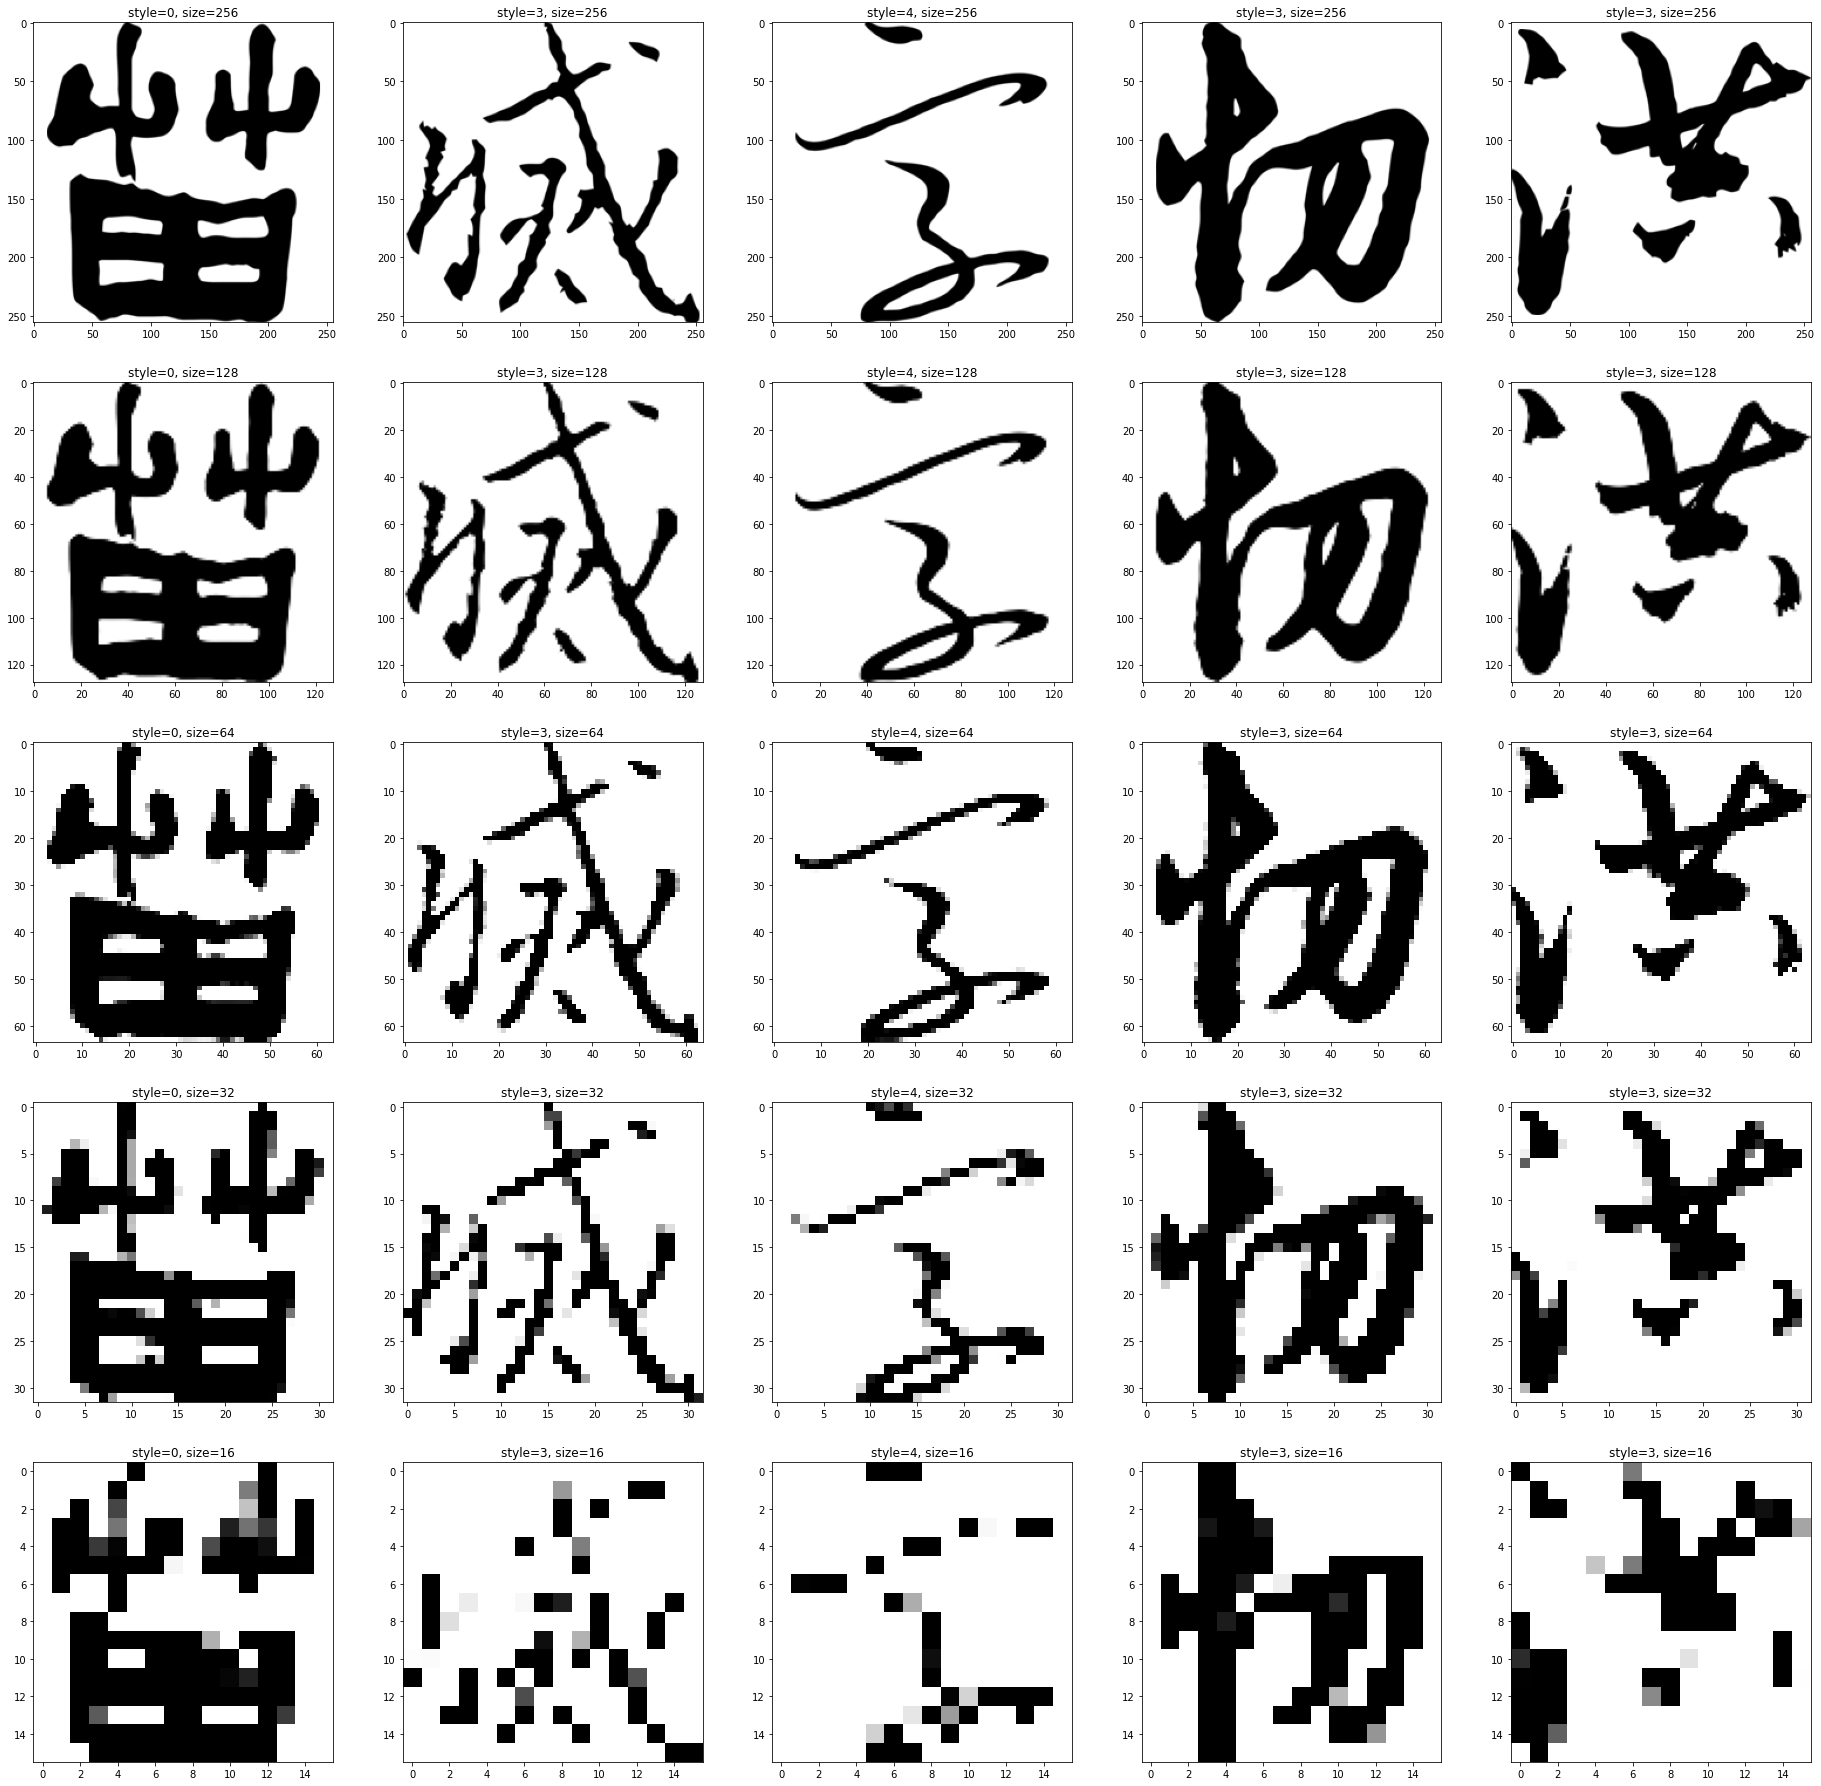

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 32))
for s in range(5):
    view_image_size = math.ceil(256 / (2 ** s))
    (X, Y) = next(custom__batch_generator(dataframe, 6, view_image_size))
    for i in range(5):
        sb = plt.subplot(5,5,s * 5 + i + 1)
        sb.set_title("style=" + str(Y[i]) + ", size=" + str(view_image_size))
        plt.imshow(X[i], cmap=plt.cm.binary)
plt.show()

In [28]:
image_size = 128
input_shape = (image_size, image_size, 3)

resnet_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=input_shape,
    pooling='max'
)
# resnet_model.trainable = False

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model = models.Sequential()
model.add(resnet_model)
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5))
model.add(layers.Activation('softmax'))
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)             

In [13]:
from tensorflow.keras.preprocessing import image as krs_image

def dataset_generator(dataframe, image_size, grayscale):
    # Create the arguments for image preprocessing
    data_gen_args = dict()

    # Create an empty data generator
    datagen = krs_image.ImageDataGenerator()
    length = len(dataframe)

    
    for i in range(length):
        try:
            # Read image from list and convert to array
            image_path = "./hanzi/" + dataframe["image"][i]
            image = krs_image.load_img(image_path, grayscale=grayscale, target_size=(image_size, image_size))
            image = datagen.apply_transform(image, data_gen_args)
            image = krs_image.img_to_array(image)

            # Read data from csv using the name of current image
            csv_row = dataframe.loc[i, dataframe.columns != 'image']
            label = csv_row['style']
            #csv_features = csv_row.drop(labels='style')
            
            X = 1 - (image / 255)
            Y = styles.index(label)
            yield (X, Y)

        except Exception as err:
            # print(err)
            pass

def dataset_from_dataframe(dataframe, batch_size = 128, image_size = 64, grayscale = True):
    length = len(dataframe)
    channels = 1
    if not grayscale:
        channels = 3

    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(dataframe_train, image_size, grayscale),
        output_types = (tf.float32, tf.int64),
        output_shapes = ([image_size, image_size, channels], ())
    )
    steps = math.ceil(len(dataframe) / batch_size)
    return dataset.repeat().batch(batch_size), steps

train_dataset, train_steps = dataset_from_dataframe(dataframe_train, grayscale = False, image_size = image_size)
validation_dataset, validation_steps = dataset_from_dataframe(dataframe_train, grayscale = False, image_size = image_size)
test_dataset, test_steps = dataset_from_dataframe(dataframe_test, grayscale = False, image_size = image_size)


In [34]:
import datetime

checkpoint_path = "checkpoints/resnet"
log_dir = "logs/fit_resnet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

history = model.fit(
    train_dataset,
    steps_per_epoch = train_steps / 20,
    validation_data = validation_dataset,
    validation_steps = validation_steps / 20,
    epochs = 1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

54/54 [==============================] - 689s 13s/step - loss: 0.0148 - accuracy: 0.9963 - val_loss: 0.0051 - val_accuracy: 0.9999


In [35]:
model.evaluate(test_dataset, steps = test_steps)

131/131 [==============================] - 399s 3s/step - loss: 0.0141 - accuracy: 0.9965


[0.01407135371118784, 0.9964814186096191]

In [54]:
tf.saved_model.save(model, "output/resnet")

INFO:tensorflow:Assets written to: output/resnet/assets
